# Imports and general setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Managing secrets
from google.colab import userdata

import gc # Garbage collector
import sys
from pathlib import Path
import os
import inspect # Access to source code


Mounted at /content/drive


In [2]:
# Working directory
%cd drive/MyDrive/GitHub/reportingAgent/PoC/
%pwd

/content/drive/MyDrive/GitHub/reportingAgent/PoC


'/content/drive/MyDrive/GitHub/reportingAgent/PoC'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data files

In [4]:
# list grid search summary files. FROM SMALLEST TO LARGEST MODEL!
list_summary_files = [
    '/content/drive/MyDrive/DSTI_DL Project/05-PROD/results/SmolLM2-135M-Instruct/an-mean-HuggingFaceTB-SmolLM2-135M-Instruct-19-082025_16-19-07.xlsx',
    '/content/drive/MyDrive/DSTI_DL Project/05-PROD/results/SmolLM2-360M-Instruct/an-mean-HuggingFaceTB-SmolLM2-360M-Instruct-19-082025_16-19-13.xlsx',
    '/content/drive/MyDrive/DSTI_DL Project/05-PROD/results/Qwen2.5-0.5B/an-mean-Qwen-Qwen2.5-0.5B-Instruct-19-082025_17-59-44.xlsx',
    '/content/drive/MyDrive/DSTI_DL Project/05-PROD/results/Llama-3.2-1B-Instruct/an-mean-meta-llama-Llama-3.2-1B-Instruct-17-082025_06-51-03.xlsx',
    '/content/drive/MyDrive/DSTI_DL Project/05-PROD/results/gpt2-xl/an-mean-openai-community-gpt2-xl-17-082025_21-34-31.xlsx',
    '/content/drive/MyDrive/DSTI_DL Project/05-PROD/results/phi-2/an-mean-tb-microsoft-phi-2-16-082025 02-50-43.xlsx',
    '/content/drive/MyDrive/DSTI_DL Project/05-PROD/results/Llama-3.2-3B-Instruct/an-mean-meta-llama-Llama-3.2-3B-Instruct-17-082025_11-58-08.xlsx',
    '/content/drive/MyDrive/DSTI_DL Project/05-PROD/results/Smol3B - tb and analysis/an-mean-HuggingFaceTB-SmolLM3-3B-17-082025_12-43-12.xlsx']

In [5]:
all_data = pd.DataFrame()

for file_path in list_summary_files:
    excel_file = pd.ExcelFile(file_path)
    for sheet_name in excel_file.sheet_names:
        df = excel_file.parse(sheet_name)
        df['source_file'] = file_path
        df['source_sheet'] = sheet_name
        all_data = pd.concat([all_data, df], ignore_index=True)

# Create 'model_ID' based on 'source_file'
# models in increasing order of number of parameters
model_names = ['SmolLM2-135M',
               'SmolLM2-360M',
               'Qwen2.5-0.5B',
               'Llama-3.2-1B',
               'gpt2-xl',
               'phi-2',
               'Llama-3.2-3B',
               'SmolLM3-3B']
all_data['model_ID'] = all_data['source_file'].apply(lambda x: next((name for name in model_names if name in x), None))

# Create 'prompt_method' based on 'source_sheet'
all_data['prompt_method'] = all_data['source_sheet'].str.extract(r'([ABC])')

display(all_data.head())

,Unnamed: 0,pad_token_id,eos_token_id,temperature,top_p,top_k,max_new_tokens,do_sample,repetition_penalty,bs_precision,...,b_1_grams,b_2_grams,b_3_grams,b_4_grams,be_sim,ce_sim,source_file,source_sheet,model_ID,prompt_method
0,0,2.0,2.0,0.3,0.3,50,300,True,1,0.749961,...,0.420349,0.443110,0.495753,0.715010,0.334453,-0.545260,/content/drive/MyDrive/DSTI_DL Project/05-PROD...,pm_A,SmolLM2-135M,A
1,1,2.0,2.0,0.3,0.6,50,300,True,1,0.740308,...,0.390206,0.425250,0.481497,0.716075,0.301516,-0.576898,/content/drive/MyDrive/DSTI_DL Project/05-PROD...,pm_A,SmolLM2-135M,A
2,2,2.0,2.0,0.3,0.9,50,300,True,1,0.745699,...,0.425216,0.465474,0.503323,0.691710,0.347085,-0.522874,/content/drive/MyDrive/DSTI_DL Project/05-PROD...,pm_A,SmolLM2-135M,A
3,3,2.0,2.0,0.7,0.3,50,300,True,1,0.744743,...,0.432468,0.473977,0.515285,0.705030,0.328746,-0.557100,/content/drive/MyDrive/DSTI_DL Project/05-PROD...,pm_A,SmolLM2-135M,A
4,4,2.0,2.0,0.7,0.6,50,300,True,1,0.737473,...,0.402830,0.433761,0.490477,0.682369,0.334694,-0.539299,/content/drive/MyDrive/DSTI_DL Project/05-PROD...,pm_A,SmolLM2-135M,A


# Plot grid search results

## Small models (max. 1B parameters)

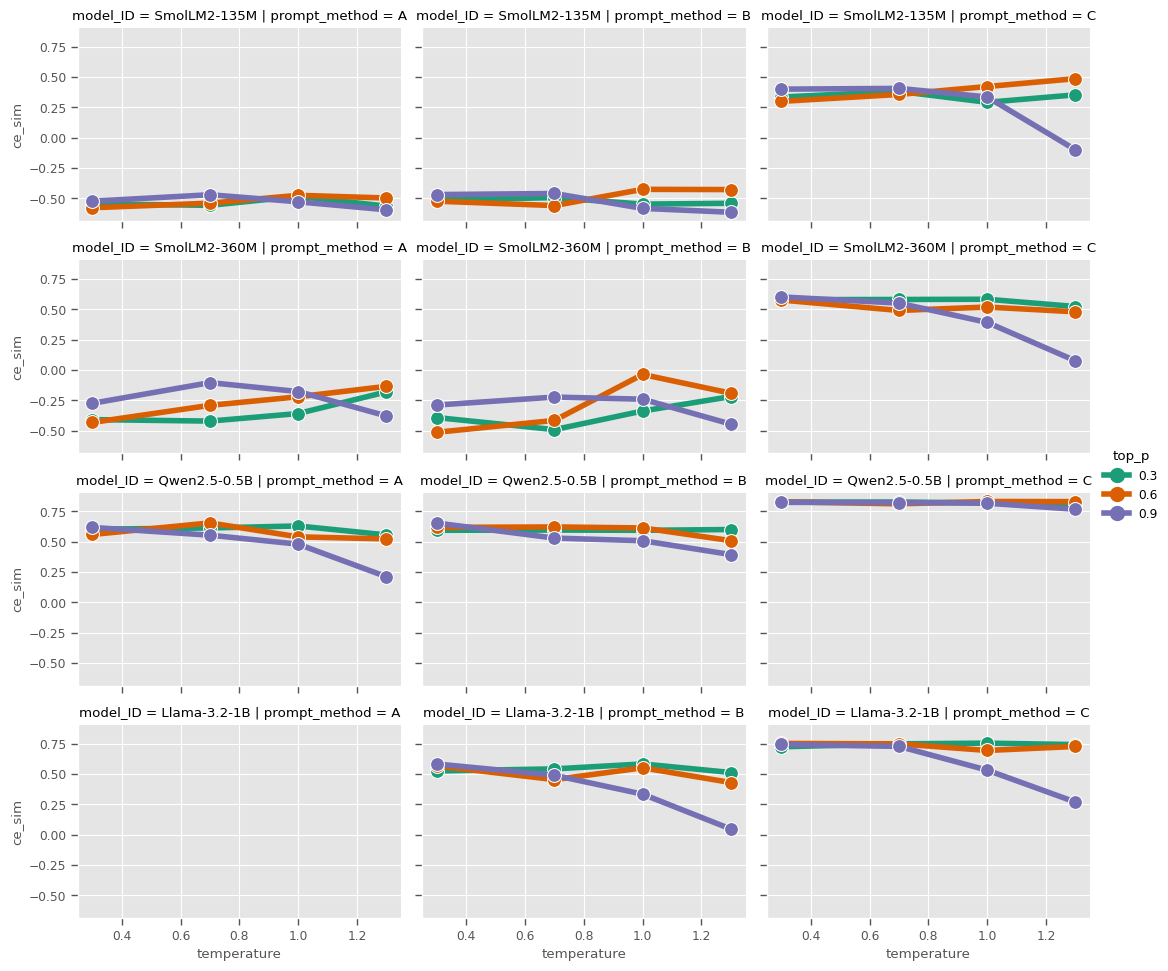

In [24]:
plt.style.use('ggplot')

sns.set_context("paper", rc={"lines.linewidth": 4})

list_selected_models = model_names[:4] # small models less than 1B

sns.relplot(data=all_data[all_data['model_ID'].isin(list_selected_models)],
            x='temperature',
            y='ce_sim',
            kind='line',
            hue='top_p',
            row='model_ID',
            row_order=list_selected_models,
            col='prompt_method',
            col_order=['A', 'B', 'C'],
            height=2.45, aspect=1.5, marker='o',
            markersize=10,
            palette='Dark2')

plt.show()

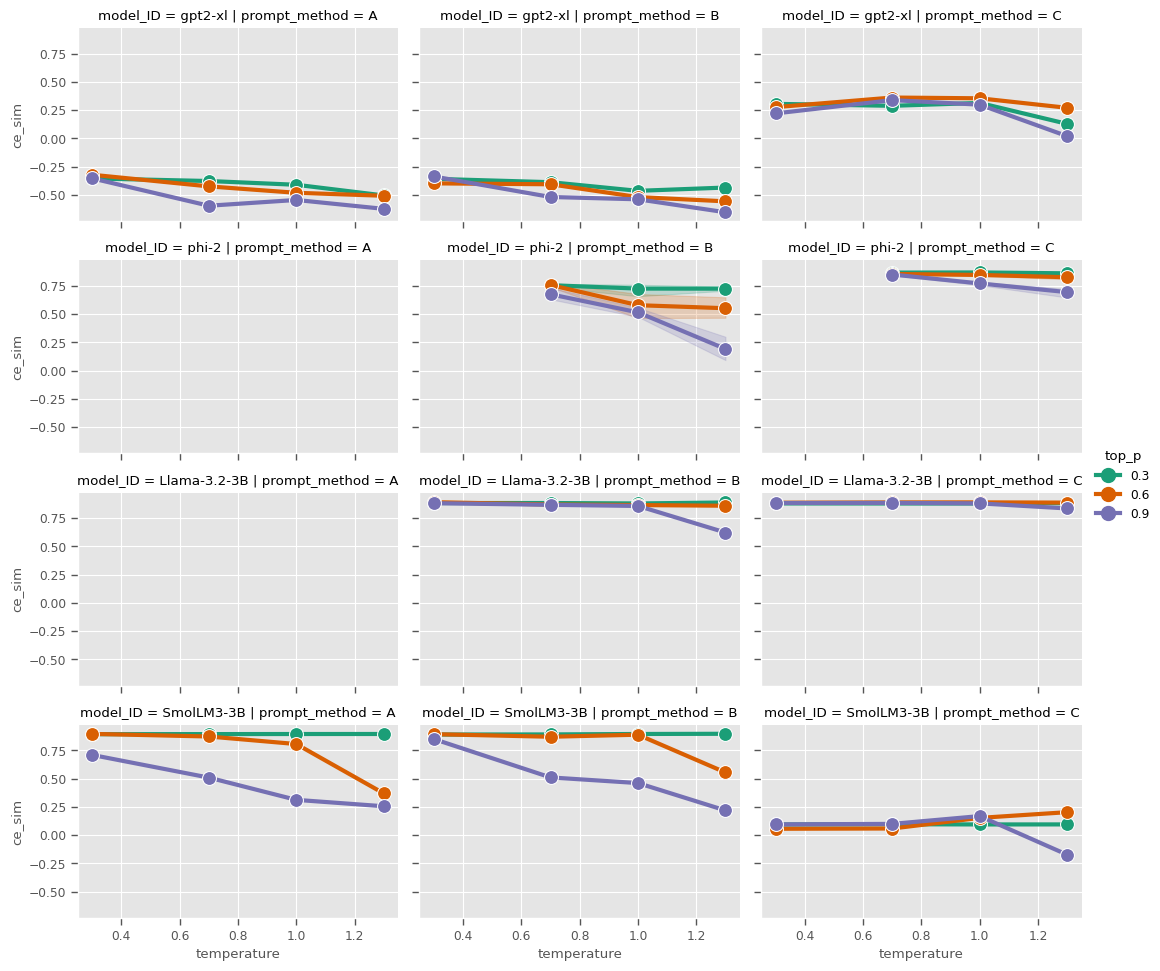

In [25]:
plt.style.use('ggplot')

sns.set_context("paper", rc={"lines.linewidth": 3})

list_selected_models = model_names[4:] # large models more than 1B

sns.relplot(data=all_data[all_data['model_ID'].isin(list_selected_models)],
            x='temperature',
            y='ce_sim',
            kind='line',
            hue='top_p',
            row='model_ID',
            row_order=list_selected_models,
            col='prompt_method',
            col_order=['A', 'B', 'C'],
            height=2.45, aspect=1.5, marker='o',
            markersize=10,
            palette='Dark2')

plt.show()